# Imports

In [1]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.2 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from collections import OrderedDict
import numpy as np
from tifffile import TiffFile
from torch.utils.data import Dataset
import random
import torchvision
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import Normalize
from torchvision.transforms import RandomRotation
import torchvision.transforms as transforms
from timeit import default_timer as timer

from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os

import torch

from transformers import SegformerModel, SegformerConfig
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# Utils from the github project

In [3]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [4]:
def numpy_parse_image_mask(image_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path : path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    # image_path = Path(image_path)
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.replace("images","masks")
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        # mask = mask[..., None]
    return image, mask


# Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


New TEST


In [45]:
import torch
from torch.utils.data import Dataset
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

class LandscapeData(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform

        # Liste des noms de fichiers dans les dossiers
        image_files = os.listdir(os.path.join(data_folder, 'images'))

        # Séparation des données en ensembles d'entraînement, de validation et de test
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

        # charger les images et les masques
        self.train_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in train_files]
        self.val_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in val_files]
        self.test_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in test_files]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        image, label = self.train_data[idx]
        channels, height, width = 4, 256, 256

        # Normalisez les valeurs des pixels dans la plage [0, 1]
        image = image.astype("float32") / 24356
        label = label.astype("int64")

        if self.transform:
            image = self.transform(image)

        # Modifier la transformation pour le masque
        label = torch.tensor(label, dtype=torch.int64)  # Convertir en torch.Tensor
        label = label.squeeze()  # Supprimer la dimension ajoutée

        target = label

        return image, target

# Exemple d'utilisation
data_folder = "drive/MyDrive/challenge-ens-master/data/dataset_UNZIPPED/train"
dataset = LandscapeData(data_folder, transform=transforms.Compose([transforms.ToTensor()]))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Itérer sur le train_loader et afficher la taille des objets
for batch_idx, (images, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Taille des images : {images.size()}")

    print(f"Taille des cibles : {targets.size()}")


Batch 1:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 2:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 3:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 4:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 5:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 6:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 7:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 8:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 9:
Taille des images : torch.Size([4, 4, 256, 256])
Taille des cibles : torch.Size([4, 256, 256])
Batch 10:
Taille des images : torch.Size([4, 4, 256, 256])
Taill

In [47]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt

# nombre de classes
num_classes = 10

class DeepLab4Channel(nn.Module):
    def __init__(self, num_classes):
        super(DeepLab4Channel, self).__init__()
        # Utilisez le modèle de base DeepLabV3 et ajustez la première couche pour accepter 4 canaux
        self.deepLabBase = models.segmentation.deeplabv3_resnet50(pretrained=True)
        # Remplacez la première couche pour accepter 4 canaux au lieu de 3
        self.deepLabBase.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modifiez la dernière couche pour avoir le nombre de classes approprié
        self.deepLabBase.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.deepLabBase(x)

import torch.optim as optim

# Fonction de perte : CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Modèle
model = DeepLab4Channel(num_classes)

# envoyer le modèle sur le périphérique GPU
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# optimiseur Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader pour l'ensemble d'entraînement
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialisation des listes pour stocker les valeurs de perte
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        targets = targets.squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Ajouter la perte d'entraînement à la liste
    train_losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# courbes de perte
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200], Loss: 1.0248
Epoch [2/200], Loss: 0.9773
Epoch [3/200], Loss: 0.8224
Epoch [4/200], Loss: 1.0909
Epoch [5/200], Loss: 0.8481
Epoch [6/200], Loss: 0.6302
Epoch [7/200], Loss: 0.6334
Epoch [8/200], Loss: 0.7050
Epoch [9/200], Loss: 0.6784
Epoch [10/200], Loss: 0.7146
Epoch [11/200], Loss: 0.5127
Epoch [12/200], Loss: 0.6142
Epoch [13/200], Loss: 0.6017
Epoch [14/200], Loss: 0.5774
Epoch [15/200], Loss: 0.5470
Epoch [16/200], Loss: 0.5736
Epoch [17/200], Loss: 0.5105
Epoch [18/200], Loss: 0.4708
Epoch [19/200], Loss: 0.4862
Epoch [20/200], Loss: 0.4188
Epoch [21/200], Loss: 0.4035
Epoch [22/200], Loss: 0.4094
Epoch [23/200], Loss: 0.3567


KeyboardInterrupt: 

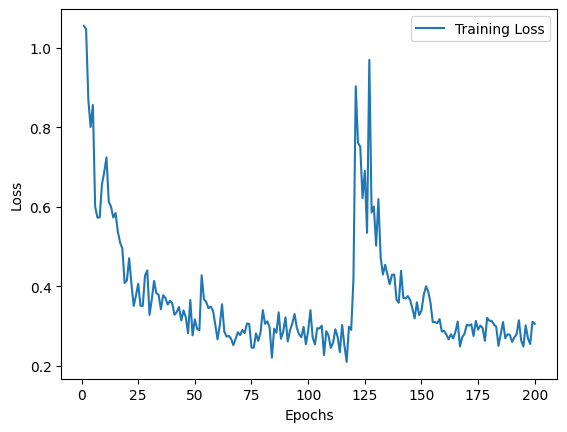

In [8]:
# Plottez les courbes de perte
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

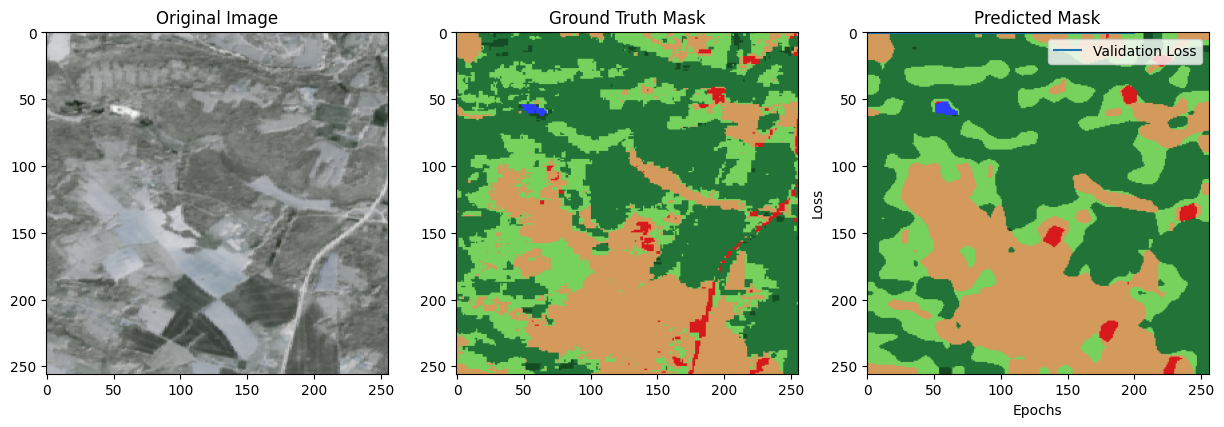

In [53]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Color palette
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],
    1: [255, 25, 236],
    2: [215, 25, 28],
    3: [211, 154, 92],
    4: [33, 115, 55],
    5: [21, 75, 35],
    6: [118, 209, 93],
    7: [130, 130, 130],
    8: [255, 255, 255],
    9: [43, 61, 255]
}

val_losses = []

# Assuming val_loader is defined in your code
for epoch in range(num_epochs):
    model.eval()
    val_epoch_losses = []

    with torch.no_grad():
        for val_images, val_targets in val_loader:
            val_images, val_targets = val_images.to(device), val_targets.to(device)
            val_outputs = model(val_images)['out']
            val_targets = val_targets.squeeze(1)
            val_loss = criterion(val_outputs, val_targets)

            # Add validation loss to the temporary list for this epoch
            val_epoch_losses.append(val_loss.item())

    # Calculate and add the average validation loss for this epoch
    avg_val_loss = np.mean(val_epoch_losses)
    val_losses.append(avg_val_loss)

    # Convert logits to predicted labels for the last batch
    _, predicted_labels = torch.max(val_outputs, dim=1)

# Visualize the results for one image from the last batch
plt.figure(figsize=(15, 5))

# Original image
original_image = val_images[0].permute(1, 2, 0).cpu().numpy()
original_image = original_image / original_image.max()  # Normalize to [0, 1]
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

# Ground truth mask
plt.subplot(1, 3, 2)
ground_truth_mask = val_targets[0].cpu().numpy()
ground_truth_mask_rgb = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)
for cls, color in CLASSES_COLORPALETTE.items():
    ground_truth_mask_rgb[ground_truth_mask == cls] = color
plt.imshow(ground_truth_mask_rgb)
plt.title("Ground Truth Mask")

# Predicted mask
plt.subplot(1, 3, 3)
predicted_mask = predicted_labels[0].cpu().numpy()
predicted_mask_rgb = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for cls, color in CLASSES_COLORPALETTE.items():
    predicted_mask_rgb[predicted_mask == cls] = color
plt.imshow(predicted_mask_rgb)
plt.title("Predicted Mask")

# Plot the validation loss curve
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
# Estimation du vecteur Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
def get_Y(mask2d):
  occurrences = np.bincount(mask2d.flatten(), minlength=10)
  Y = occurrences / np.sum(occurrences)
  return Y

def klmetric(y_t, y_p, eps):
  sum = 0
  for i in range(len(y_t)):
    sum += (y_t[i]+eps)*np.log((y_t[i] + eps) / (y_p[i] + eps))
  return sum

In [55]:
def mesure_on_batch(batch_gt, batch_predi, batch_size=4):
  mean = 0
  for i in range(batch_size):
    Y_pred = get_Y(batch_gt[i].cpu().numpy())
    Y_truth = get_Y(batch_predi[i].cpu().numpy())
    mean += klmetric(Y_truth, Y_pred, 10e-7)
  return mean / batch_size

def mesure_on_dataloader(test_dataloader):

  mean = 0
  for i in range(len(test_dataloader)):
    test_inputs, test_targets = next(iter(val_loader))
    test_pixels_values = test_inputs.to(device)
    model.eval()
    with torch.no_grad():
      test_outputs = model(pixel_values=test_pixels_values)
      test_logits = test_outputs.logits

    _, predicted_labels = torch.max(test_logits, dim=1)

    mean += mesure_on_batch(test_targets, predicted_labels)

  return mean / len(test_dataloader)

In [56]:
mesure_on_dataloader(val_loader)

TypeError: DeepLab4Channel.forward() got an unexpected keyword argument 'pixel_values'